# Set up environment

In [1]:
source("pilot_config.R")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following o

Recall that after the tutorial one, we have created the hts-pilot-2018.RData.

```
scratch
└── analysis_output  
    ├── out  
    │   └── hts-pilot-2018.RData        
    └── img  
```

In [2]:
OUTDIR

[1] "~/work/scratch/analysis_output/out"

In [3]:
# file directory
cntfile <- file.path(OUTDIR, "hts-pilot-2018.RData")

# Read in results

In [4]:
### Import count data
attach(cntfile)
tools::md5sum(cntfile)

~/work/scratch/analysis_output/out/hts-pilot-2018.RData 
                                                     NA

In [5]:
### Import metadata
tools::md5sum(METADTFILE)

mtdf <- readr::read_tsv(METADTFILE) %>%
    mutate_at(vars(
        `Label`,
        `Strain`,
        `Media`,
        `enrichment_method`,
        `library#`,
        `libprep_person`,
        `experiment_person`
    ), factor)

~/work/HTS2018-notebooks/josh/info/2018_pilot_metadata_anon.tsv 
                                                             NA

Parsed with column specification:
cols(
  Label = col_character(),
  RNA_sample_num = col_integer(),
  Media = col_character(),
  Strain = col_character(),
  Replicate = col_integer(),
  experiment_person = col_character(),
  libprep_person = col_character(),
  enrichment_method = col_character(),
  RIN = col_double(),
  concentration_fold_difference = col_double(),
  `i7 index` = col_character(),
  `i5 index` = col_character(),
  `i5 primer` = col_character(),
  `i7 primer` = col_character(),
  `library#` = col_integer()
)


Recall that there are 204 samples and 8498 genes

In [6]:
head(mtdf)

Label,RNA_sample_num,Media,Strain,Replicate,experiment_person,libprep_person,enrichment_method,RIN,concentration_fold_difference,i7 index,i5 index,i5 primer,i7 primer,library#
2_MA_C,2,YPD,H99,2,expA,prepA,MA,10.0,1.34,ATTACTCG,AGGCTATA,i501,i701,1
9_MA_C,9,YPD,mar1d,3,expA,prepA,MA,10.0,2.23,ATTACTCG,GCCTCTAT,i502,i701,2
10_MA_C,10,YPD,mar1d,4,expA,prepA,MA,9.9,4.37,ATTACTCG,AGGATAGG,i503,i701,3
14_MA_C,14,TC,H99,2,expA,prepA,MA,10.0,1.57,ATTACTCG,TCAGAGCC,i504,i701,4
15_MA_C,15,TC,H99,3,expA,prepA,MA,9.9,2.85,ATTACTCG,CTTCGCCT,i505,i701,5
21_MA_C,21,TC,mar1d,3,expA,prepA,MA,10.0,1.81,ATTACTCG,TAAGATTA,i506,i701,6


# Check the label between metadata and mapping results

Recall that we got two data frames in the previous tutorial:  
- genecounts: gene counts for each **sample**
    - Note: We will need to convert it into gene counts for each **library** later
- mapresults: the mapping results 
    - Note: There are 204 samples

The metadata (`mtdf`) contains the information of each sample. Here we need to make sure if the label in the metadata matches the sample names we have in `mapresults` and `genecount`

The code chunk below allows us to check to see if we can match the labels to the those in the metadata file. There should not be any output from the code chunk.

In [7]:
### Use setdiff to check to see if we can match the labels to the those in the metadata file
myregex <- "_[A-Z](100|[1-9][0-9]?)_L00[1-4].*"

mapresults$expid %>%
    str_replace(myregex, "") %>%
    setdiff(mtdf$Label)

mtdf$Label %>%
    setdiff(str_replace(mapresults$expid, myregex, ""))

character(0)

character(0)

# Construct gene count matrix for each library

Add the "Label" to the count matrix and mapping results, then merge in phenotype data (by Label)

In [8]:
### Add "Label" to genecounts
genecounts %>%
    mutate(Label = str_replace(expid, myregex, "")) ->
    annogenecnts

In [9]:
### Collapse the gene counts within each label
annogenecnts %>%
    select(-expid) %>%
    group_by(Label) %>%
    summarize_all(sum) %>%
    gather(gene, value, -Label) %>% 
    spread(Label, value) ->
    annogenecnts0

Show the resulting data frame in each step

In [10]:
genecounts[1:6, 1:6]

expid,CNAG_00001,CNAG_00002,CNAG_00003,CNAG_00004,CNAG_00005
1_MA_J_S18_L001_ReadsPerGene.out.tab,0,66,38,74,33
1_MA_J_S18_L002_ReadsPerGene.out.tab,0,59,25,79,25
1_MA_J_S18_L003_ReadsPerGene.out.tab,0,74,27,79,32
1_MA_J_S18_L004_ReadsPerGene.out.tab,0,66,22,69,24
1_RZ_J_S26_L001_ReadsPerGene.out.tab,0,50,16,51,26
1_RZ_J_S26_L002_ReadsPerGene.out.tab,0,45,7,51,31


In [11]:
annogenecnts[1:6, c(colnames(annogenecnts)[1:6], "Label")]

expid,CNAG_00001,CNAG_00002,CNAG_00003,CNAG_00004,CNAG_00005,Label
1_MA_J_S18_L001_ReadsPerGene.out.tab,0,66,38,74,33,1_MA_J
1_MA_J_S18_L002_ReadsPerGene.out.tab,0,59,25,79,25,1_MA_J
1_MA_J_S18_L003_ReadsPerGene.out.tab,0,74,27,79,32,1_MA_J
1_MA_J_S18_L004_ReadsPerGene.out.tab,0,66,22,69,24,1_MA_J
1_RZ_J_S26_L001_ReadsPerGene.out.tab,0,50,16,51,26,1_RZ_J
1_RZ_J_S26_L002_ReadsPerGene.out.tab,0,45,7,51,31,1_RZ_J


In [12]:
annogenecnts0[1:6, 1:6]

gene,1_MA_J,1_RZ_J,10_MA_C,10_RZ_C,11_MA_J
CNAG_00001,0,0,0,0,0
CNAG_00002,265,204,269,76,130
CNAG_00003,112,40,171,24,124
CNAG_00004,301,207,407,141,272
CNAG_00005,114,125,50,25,38
CNAG_00006,1904,1295,3571,1015,2073


# Metadata

Add "Label" to read map results and merge in phenotype data (-> annomapres)

In [13]:
mapresults %>%
    mutate(Label = str_replace(expid, myregex, "")) %>%
    full_join(mtdf, by = "Label") ->
    annomapres

Warning message:
“Column `Label` joining character vector and factor, coercing into character vector”

In [14]:
grpvars <- vars(Label, Strain, Media, experiment_person, libprep_person, enrichment_method)
sumvars <- vars(prob.gene, prob.nofeat, prob.unique, depth)

annomapres %>%
    group_by_at(grpvars) %>%
    summarize_at(sumvars, mean) -> 
    annomapres0

In [15]:
head(annomapres)

expid,ngenemap,namb,nmulti,nnofeat,nunmap,depth,prob.gene,prob.nofeat,prob.unique,⋯,experiment_person,libprep_person,enrichment_method,RIN,concentration_fold_difference,i7 index,i5 index,i5 primer,i7 primer,library#
1_MA_J_S18_L001_ReadsPerGene.out.tab,2399781,647,66100,20347,2690,2489565,0.9639359,0.008172914,0.9721088,⋯,expA,prepB,MA,10,3.64,CGCTCATT,AGGCTATA,i501,i703,18
1_MA_J_S18_L002_ReadsPerGene.out.tab,2362228,652,65234,20004,2684,2450802,0.9638592,0.008162226,0.9720214,⋯,expA,prepB,MA,10,3.64,CGCTCATT,AGGCTATA,i501,i703,18
1_MA_J_S18_L003_ReadsPerGene.out.tab,2436776,697,66538,20549,2672,2527232,0.9642075,0.008131030,0.9723385,⋯,expA,prepB,MA,10,3.64,CGCTCATT,AGGCTATA,i501,i703,18
1_MA_J_S18_L004_ReadsPerGene.out.tab,2417485,616,65066,20505,2585,2506257,0.9645798,0.008181523,0.9727614,⋯,expA,prepB,MA,10,3.64,CGCTCATT,AGGCTATA,i501,i703,18
1_RZ_J_S26_L001_ReadsPerGene.out.tab,2366742,1431,395848,768146,7218,3539385,0.6686874,0.217028100,0.8857155,⋯,expA,prepB,RZ,10,3.64,GAGATTCC,AGGCTATA,i501,i704,26
1_RZ_J_S26_L002_ReadsPerGene.out.tab,2331658,1337,388079,755654,7022,3483750,0.6692954,0.216908217,0.8862037,⋯,expA,prepB,RZ,10,3.64,GAGATTCC,AGGCTATA,i501,i704,26


In [16]:
head(annomapres0)

Label,Strain,Media,experiment_person,libprep_person,enrichment_method,prob.gene,prob.nofeat,prob.unique,depth
1_MA_J,H99,YPD,expA,prepB,MA,0.9641456,0.008161923,0.9723075,2493464
1_RZ_J,H99,YPD,expA,prepB,RZ,0.6689001,0.217095621,0.8859957,3541358
10_MA_C,mar1d,YPD,expA,prepA,MA,0.9618651,0.009818573,0.9716837,3282785
10_RZ_C,mar1d,YPD,expA,prepA,RZ,0.7497438,0.200651686,0.9503955,1742594
11_MA_J,mar1d,YPD,expA,prepB,MA,0.9669597,0.008717898,0.9756776,2062181
11_RZ_J,mar1d,YPD,expA,prepB,RZ,0.7030020,0.195547151,0.8985491,2621913


# Store the results

In [17]:
outfile <- file.path(OUTDIR, "HTS-Pilot-Annotated-STAR-counts.RData")
save(mtdf, annogenecnts0, annomapres0, annogenecnts, annomapres, file = outfile)
tools::md5sum(outfile)

~/work/scratch/analysis_output/out/HTS-Pilot-Annotated-STAR-counts.RData 
                                                                      NA

# Visualize the mapping results

In [18]:
### Figures for mapping results
mygeom <-  geom_point(position = position_jitter(w = 0.3, h = 0))
mypal <- scale_colour_manual(name="",  values =brewer.pal(3,"Set1"))
mytheme <-  theme(axis.text.x = element_text(angle = 90, hjust = 1)) + theme_bw()
myfacet <- facet_grid(Strain~ Media, drop=TRUE, scales="free_x", space="free")

### Show the fraction of unique mapped reads among all reads (prob.unique)

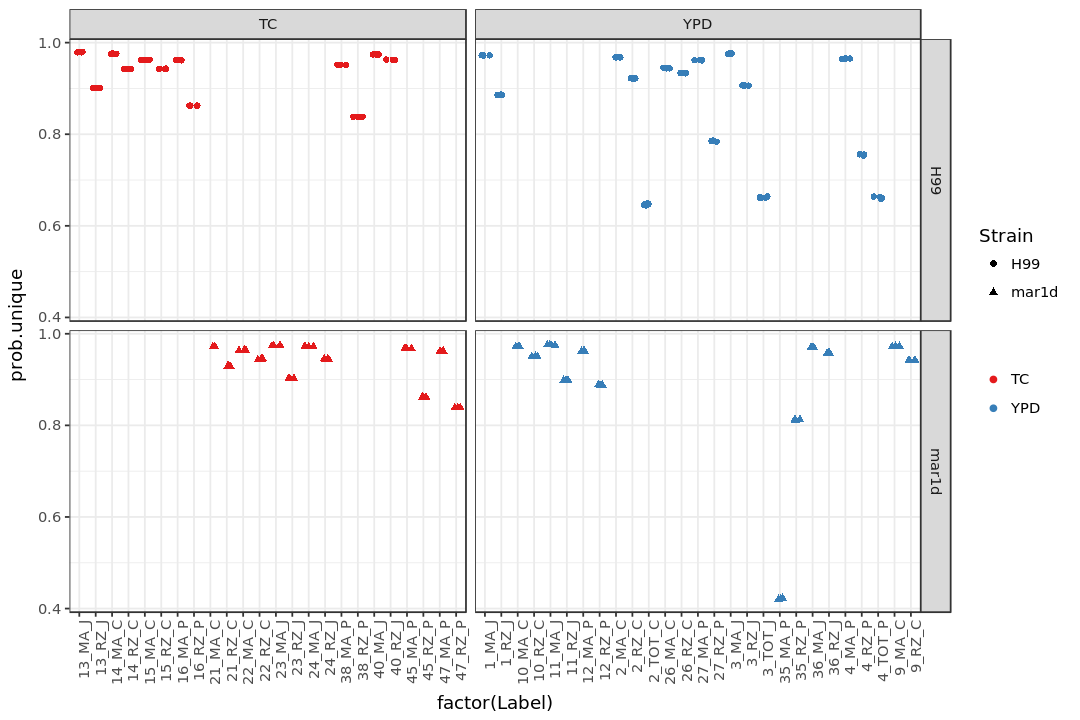

In [19]:
options(repr.plot.width = 9, repr.plot.height = 6)

p1 <- ggplot(annomapres, 
             aes(x = factor(Label), 
                 y = prob.unique, 
                 shape = Strain, 
                 color = Media)) +
        myfacet + 
        mygeom + 
        mytheme + 
        mypal

print(p1)

### Show the fraction of reads mapped to genes (prob.gene)

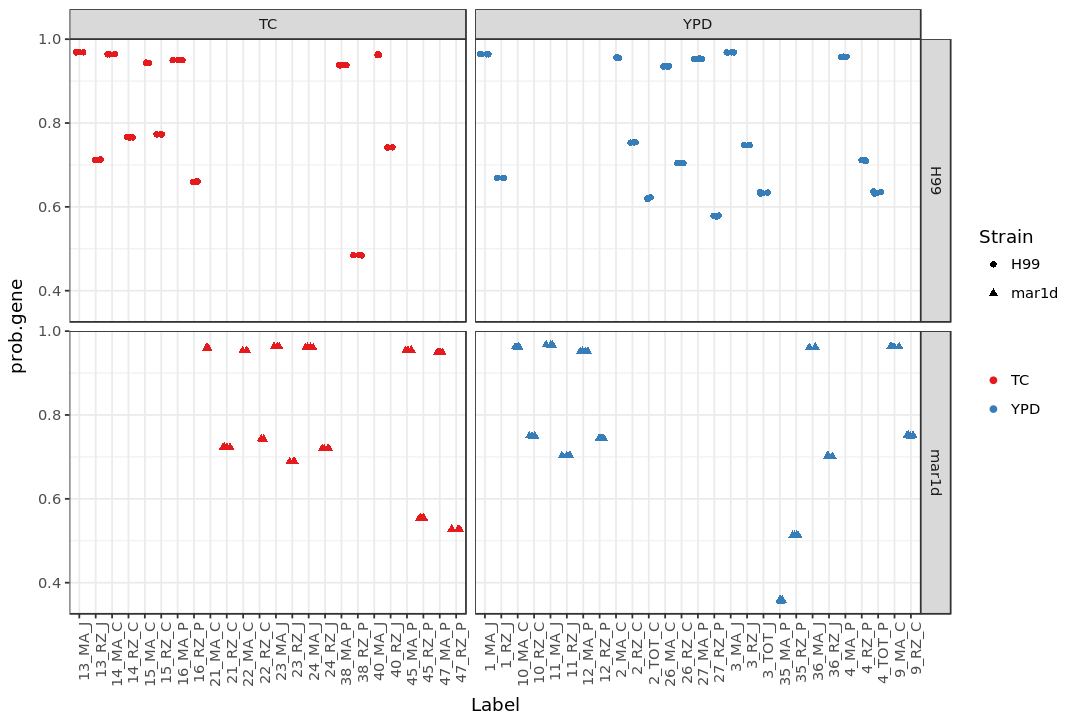

In [20]:
options(repr.plot.width = 9, repr.plot.height = 6)

p2 <- ggplot(annomapres, 
             aes(x = Label, 
                 y = prob.gene, 
                 shape = Strain, 
                 color = Media)) +
        myfacet +
        mygeom +
        mytheme + 
        mypal
  
print(p2)

### Show the fraction of reads categorized as "no feature" (prob.nofeat)

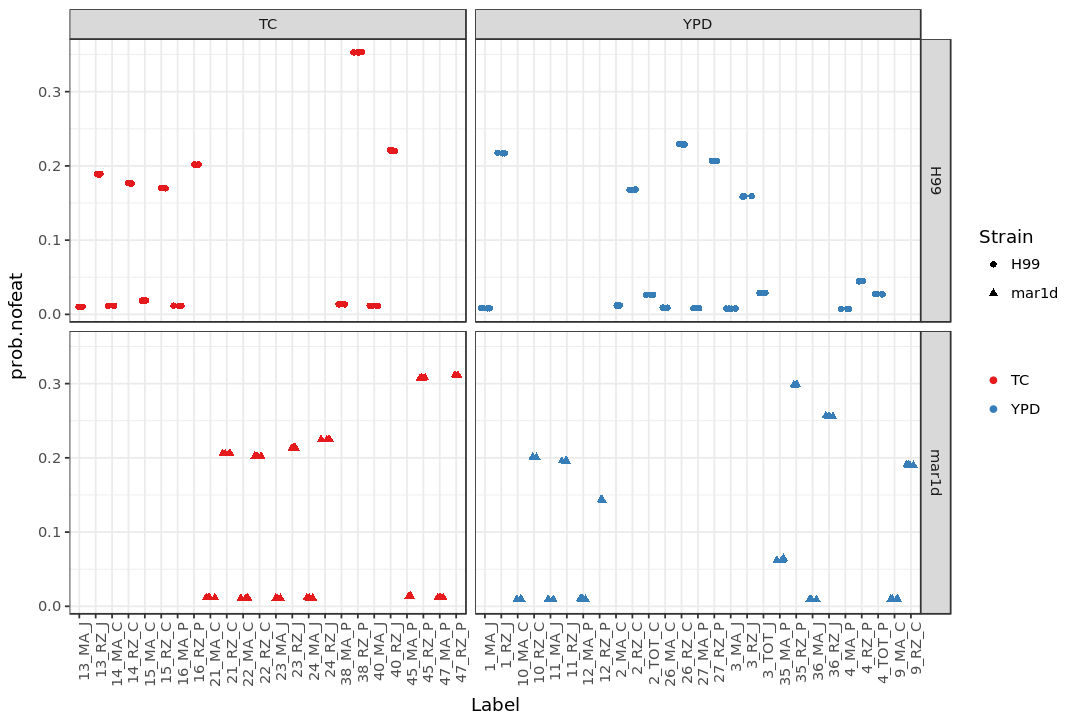

In [21]:
options(repr.plot.width = 9, repr.plot.height = 6)

p3 <- ggplot(annomapres, 
             aes(x = Label, 
                 y = prob.nofeat, 
                 shape = Strain, 
                 color = Media))+
        myfacet +
        mygeom + 
        mytheme + 
        mypal

print(p3)

### Show the number of all the reads in each sample 
(Note: depth = ngenemap + namb + nmulti + nnofeat + nunmap)

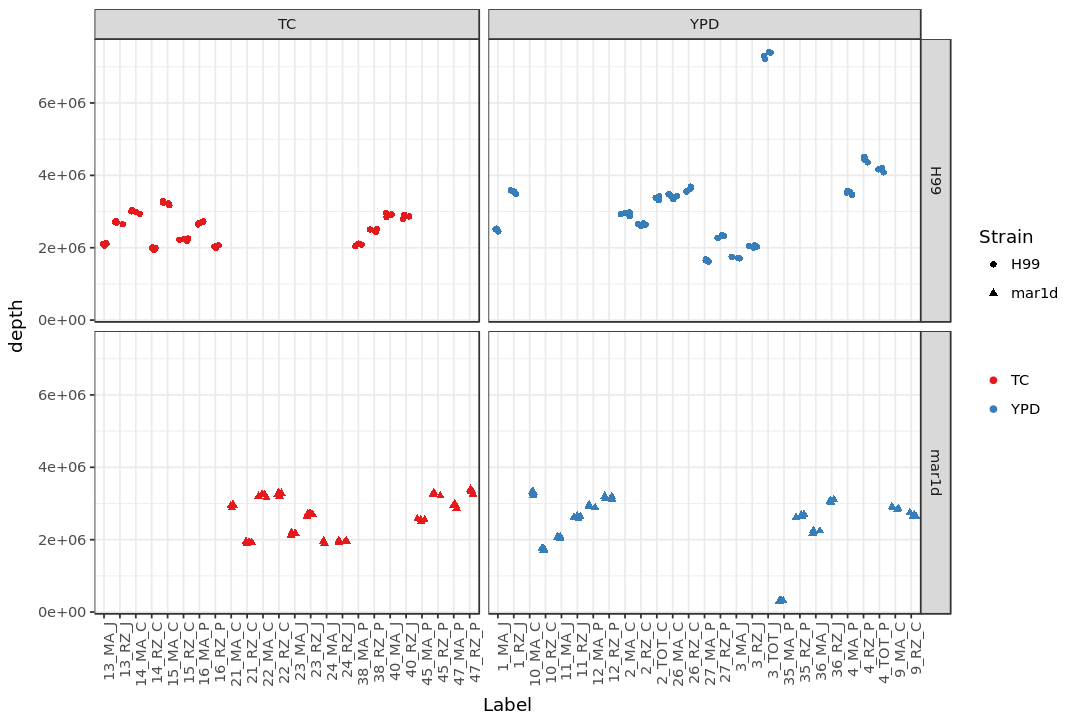

In [22]:
options(repr.plot.width = 9, repr.plot.height = 6)

p4 <- ggplot(annomapres, 
             aes(x = Label, 
                 y = depth, 
                 shape = Strain, 
                 color = Media))+
        myfacet +
        mygeom +
        mytheme +
        mypal

print(p4)

### Store the plots

In [23]:
png(file.path(IMGDIR, "p1.png"), height = 480 * 2, width = 480 * 2)
plot(p1)
graphics.off()

png(file.path(IMGDIR, "p2.png"), height = 480 * 2, width = 480 * 2)
plot(p2)
graphics.off()

png(file.path(IMGDIR, "p3.png"), height = 480 * 2, width = 480 * 2)
plot(p3)
graphics.off()

png(file.path(IMGDIR, "p4.png"), height = 480 * 2, width = 480 * 2)
plot(p4)
graphics.off()